In [59]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os

from keras import layers
from keras.models import load_model
from keras.preprocessing import image

BASE_DIR = 'Dataset/'
BATCH_SIZE = 64
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
IMAGE_SIZE = (128,128)



train_df, test_df = tf.keras.preprocessing.image_dataset_from_directory(directory=BASE_DIR,
                                                                        color_mode='grayscale',
                                                                        label_mode='int',
                                                                        batch_size=BATCH_SIZE,
                                                                        image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                                        validation_split=.3,
                                                                        subset='both',
                                                                        shuffle=True,
                                                                        seed=0)

Found 6400 files belonging to 4 classes.
Using 4480 files for training.
Using 1920 files for validation.


In [21]:
labels = test_df.class

images=samples[0]
target = samples[1]

plt.figure(figsize=(20,20))
for i in range(BATCH_SIZE):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.2,wspace=.2)
    plt.imshow(train_df[i], cmap='gray')
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

AttributeError: '_BatchDataset' object has no attribute '__next__'

In [8]:
# Non Demented Images
non_images = glob(BASE_DIR + 'Non_Demented/*.jpg')
print('Amount of Non Demented Images:',len(non_images))

# Very Mild Demented Images
very_mild_images = glob(BASE_DIR + '/Very_Mild_Demented/*.jpg')
print('Amount of Very Mild Demented Images:',len(very_mild_images))

# Mild Demented Images
mild_images = glob(BASE_DIR + '/Mild_Demented/*.jpg')
print('Amount of Mild Demented Images:',len(mild_images))

# Moderate Demented Images
moderate_images = glob(BASE_DIR + '/Moderate_Demented/*.jpg')
print('Amount of Moderate Demented Images:',len(moderate_images))

Amount of Non Demented Images: 3200
Amount of Very Mild Demented Images: 2240
Amount of Mild Demented Images: 896
Amount of Moderate Demented Images: 64


In [7]:
print(len(non_images))

3200


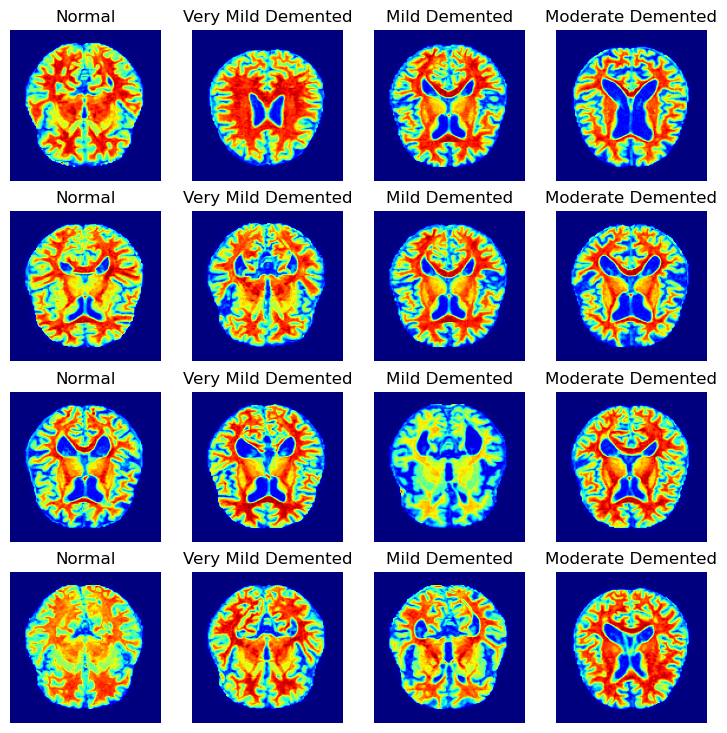

In [57]:
plt.figure(figsize=(9,9))

colorMap = 'jet'
rows = 4

j=1
# Plot image for normal lungs
for i in range(rows):

    # Build Image & store in variable
    non_image = np.asarray(plt.imread(non_images[i]))
    very_mild_image = np.asarray(plt.imread(very_mild_images[i]))
    mild_image = np.asarray(plt.imread(mild_images[i]))
    moderate_image = np.asarray(plt.imread(moderate_images[i]))

    plt.subplot(rows, 4, j)
    plt.imshow(non_image, cmap=colorMap)
    plt.title("Normal")
    plt.axis('off')
    j = j+1
    
    plt.subplot(rows,4,j)
    plt.imshow(very_mild_image, cmap=colorMap)
    plt.title('Very Mild Demented')
    plt.axis('off')
    j = j+1

    plt.subplot(rows,4,j)
    plt.imshow(mild_image, cmap= colorMap)
    plt.title('Mild Demented')
    plt.axis('off')
    j = j+1

    plt.subplot(rows,4,j)
    plt.imshow(moderate_image, cmap=colorMap)
    plt.title('Moderate Demented')
    plt.axis('off')
    j = j+1

In [68]:
# Input Variables
EPOCHS = 15

# Input matric that uses 2x2 pixels.
MATRIX = (3,3)

# Build Convolution Neural Network
model = keras.Sequential(name='Alzheimers_CNN', layers=
    [
        keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1), name='Input_Layer'),
        layers.Rescaling(1./255, name='Res_Layer1'),
        
        layers.Conv2D(64, MATRIX, padding='same', activation='relu', name='Conv_Layer1'),
        layers.MaxPooling2D(name='Max_Pooling1'),

        layers.Conv2D(64, MATRIX, padding='same', activation='relu', name='Conv_Layer2'),
        layers.MaxPooling2D(name='Max_Pooling2'),

        layers.Conv2D(64, MATRIX, padding='same', activation='relu', name='Conv_Layer3'),
        layers.MaxPooling2D(name='Max_Pooling3'),
        
        layers.Flatten(name='Flatten_Layer'),
        layers.Dense(32, activation='relu', name='Dense_layer'),
        layers.Dense(4, name='Final_Output')
    ]
)

# Print Out Model Architecture
print(model.summary())

# Run & Compile Deep Learning Model
model.compile(optimizer='adam',             # Use the Adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),   # Use binary crossentropy since this is a binary output
              metrics=['accuracy'])         # Optimize Accuracy of model

# Create a Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',   # Metric to watch during training 
                                            patience=2)           # Continue training 3 epocks past a decrease in the monitor feature

# Train model
history=model.fit(train_df,                 # Data to train on       
                  validation_data=test_df,  # Validation Data
                  epochs=EPOCHS,            # Number of Epochs 
                  batch_size=BATCH_SIZE,     # Number of samples to train in SGD at a time
                  callbacks=[callback])      # Stop early if there is no increase in model metrics

# Evaluate Model
test_loss, test_score = model.evaluate(test_df,                # What data to evaluate model on          
                                       batch_size=BATCH_SIZE)   # Number of samples to train in SGD at a time

# # Delete Old Model & Save New Keras Model
os.remove('Alzheimers_CNN_Model.h5')
model.save("Alzheimers_CNN_Model.h5")

# Print out Final results
print(f'''

        Final Model Results
----------------------------------
Accuracy: {round(test_score * 100,1)}%
Loss: {test_loss}
''')

Model: "LungClassifier_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Res_Layer1 (Rescaling)      (None, 128, 128, 1)       0         
                                                                 
 Conv_Layer1 (Conv2D)        (None, 128, 128, 64)      640       
                                                                 
 Max_Pooling1 (MaxPooling2D)  (None, 64, 64, 64)       0         
                                                                 
 Conv_Layer2 (Conv2D)        (None, 64, 64, 64)        36928     
                                                                 
 Max_Pooling2 (MaxPooling2D)  (None, 32, 32, 64)       0         
                                                                 
 Conv_Layer3 (Conv2D)        (None, 32, 32, 64)        36928     
                                                                 
 Max_Pooling3 (MaxPooling2D)  (None, 16, 16, 64)